#### Lesson 15 Chapter 5 LangGraphによるエージェントの構築

Lesson 15 Chapter 5.3 準備

In [7]:
# 必要なモジュールをインポート
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

# 環境変数の読み込み
load_dotenv("../.env")
os.environ['OPENAI_API_KEY'] = os.environ['API_KEY']

# モデル名
MODEL_NAME = "gpt-4o-mini"

Lesson 15 Chapter 5.4 ステートグラフの作成

In [8]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

# ステートの定義
class State(TypedDict):
    # データを保存する属性
    messages: Annotated[list, add_messages]

# ステートグラフの作成
graph_builder = StateGraph(State)

Lesson 15 Chapter 5.5 グラフの作成

In [9]:
# 言語モデルの定義
llm = ChatOpenAI(model_name=MODEL_NAME)

# チャットボットノードの作成
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# グラフにチャットボットノードを追加
graph_builder.add_node("chatbot", chatbot)

# 開始ノードの指定
graph_builder.set_entry_point("chatbot")
# 終了ノードの指定
graph_builder.set_finish_point("chatbot")

# 実行可能なステートグラフの作成
graph = graph_builder.compile()

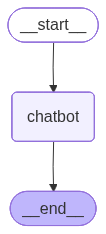

In [10]:
# グラフの可視化
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

Lesson 15 Chapter 5.6 動作確認

In [11]:
# グラフの実行
response = graph.invoke({"messages": [("user", "光の三原色は？")]})

# 結果の表示
print(response)

{'messages': [HumanMessage(content='光の三原色は？', additional_kwargs={}, response_metadata={}, id='82440c9d-8ab1-4be0-aa28-5b75a1d3b343'), AIMessage(content='光の三原色は、赤（Red）、緑（Green）、青（Blue）です。これらの色を組み合わせることで、さまざまな色を表現することができます。この色の組み合わせは、RGBカラーシステムとして知られています。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 64, 'prompt_tokens': 14, 'total_tokens': 78, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'finish_reason': 'stop', 'logprobs': None}, id='run-2e1ab676-6635-4af2-ac0e-b001b690de83-0', usage_metadata={'input_tokens': 14, 'output_tokens': 64, 'total_tokens': 78, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}


In [16]:
# 言語モデルからの回答のみを表示
print(response["messages"][-1].content)

光の三原色は、赤（Red）、緑（Green）、青（Blue）です。これらの色を組み合わせることで、さまざまな色を表現することができます。この色の組み合わせは、RGBカラーシステムとして知られています。


Lesson 15 Chapter 5.7 チャットボットシステムの作成

In [18]:
# グラフの実行と結果の表示
def stream_graph_updates(user_input: str):
    # 結果をストリーミングで得る
    events = graph.stream({"messages": [("user", user_input)]})
    for event in events:
        for value in event.values():
            print("回答", value["messages"][-1].content, flush=True)

# チャットボットのループ
while True:
    user_input = input("質問:")
    if user_input.strip()=="":
        print("ありがとうございました!")
        break
    print("質問:", user_input, flush=True)
    stream_graph_updates(user_input)


質問: こんにちは！
回答 こんにちは！どうぞ、お話ししたいことがあれば教えてください。
質問: aで始まる英単語を5つ教えて
回答 もちろんです。「a」で始まる英単語を5つご紹介します。

1. apple（リンゴ）
2. animal（動物）
3. amazing（驚くべき）
4. adventure（冒険）
5. artist（アーティスト）

他にも知りたい単語があれば教えてください！
質問: 3つ目の英単語は何ですか？
回答 「3つ目の英単語」というのが具体的に何を指しているのか、もう少し詳しく教えていただけますか？特定のリストや文脈があれば、それに基づいてお答えします。
ありがとうございました!


Lesson 15 Chapter 5.8 記憶を持たせる

In [19]:
from langgraph.checkpoint.memory import MemorySaver

# チェックポインタの作成
memory = MemorySaver()

# 記憶を持つ実行可能なステートグラフの作成
memory_graph = graph_builder.compile(checkpointer=memory)

In [20]:
# グラフの実行と結果の表示
def stream_graph_updates(user_input: str):
    events = memory_graph.stream(
        {"messages": [("user", user_input)]},
        {"configurable": {"thread_id": "1"}},
        stream_mode="values")
    # 結果をストリーミングで得る
    for event in events:
        print(event["messages"][-1].content, flush=True)

# チャットボットのグループ
while True:
    user_input = input("質問:")
    if user_input.strip()=="":
        print("ありがとうございました!")
        break
    stream_graph_updates(user_input)

こんにちは！
こんにちは！どういったことをお話ししましょうか？
aで始まる英単語を5つ教えて
もちろんです！以下は「a」で始まる英単語を5つ挙げます：

1. Apple（リンゴ）
2. Amazing（驚くべき）
3. Adventure（冒険）
4. Artist（アーティスト）
5. Atmosphere（雰囲気、大気）

他に知りたい単語があれば教えてください！
4つ目の英単語は何ですか？
4つ目の英単語は「Artist」です。意味は「アーティスト」や「芸術家」です。何か他に知りたいことがあれば教えてください！
ありがとうございました!
